In [1]:
import numpy as np
import pandas as pd
from ase.io import read, write
from ase import units
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import seaborn as sns
from scipy.stats import kstest
import statsmodels.api as sm


plt.rc('font', family="sans-serif", weight="bold")          # controls default text sizes
plt.rc('axes', labelsize=15, titlesize=15)    # x and y axes
plt.rc('xtick', labelsize=15)    # Major Ticks
plt.rc('ytick', labelsize=15)    # Major Ticks
plt.rc('xtick.minor', visible=True)    # Minor Ticks
plt.rc('ytick.minor', visible=True)    # Minor Ticks
plt.rc('legend', fontsize=10)    # Legend
plt.rc('figure', titlesize=10)  # Figure title


plt.rcParams['figure.dpi'] = 300
print(plt.rcParams['font.family'])

['sans-serif']


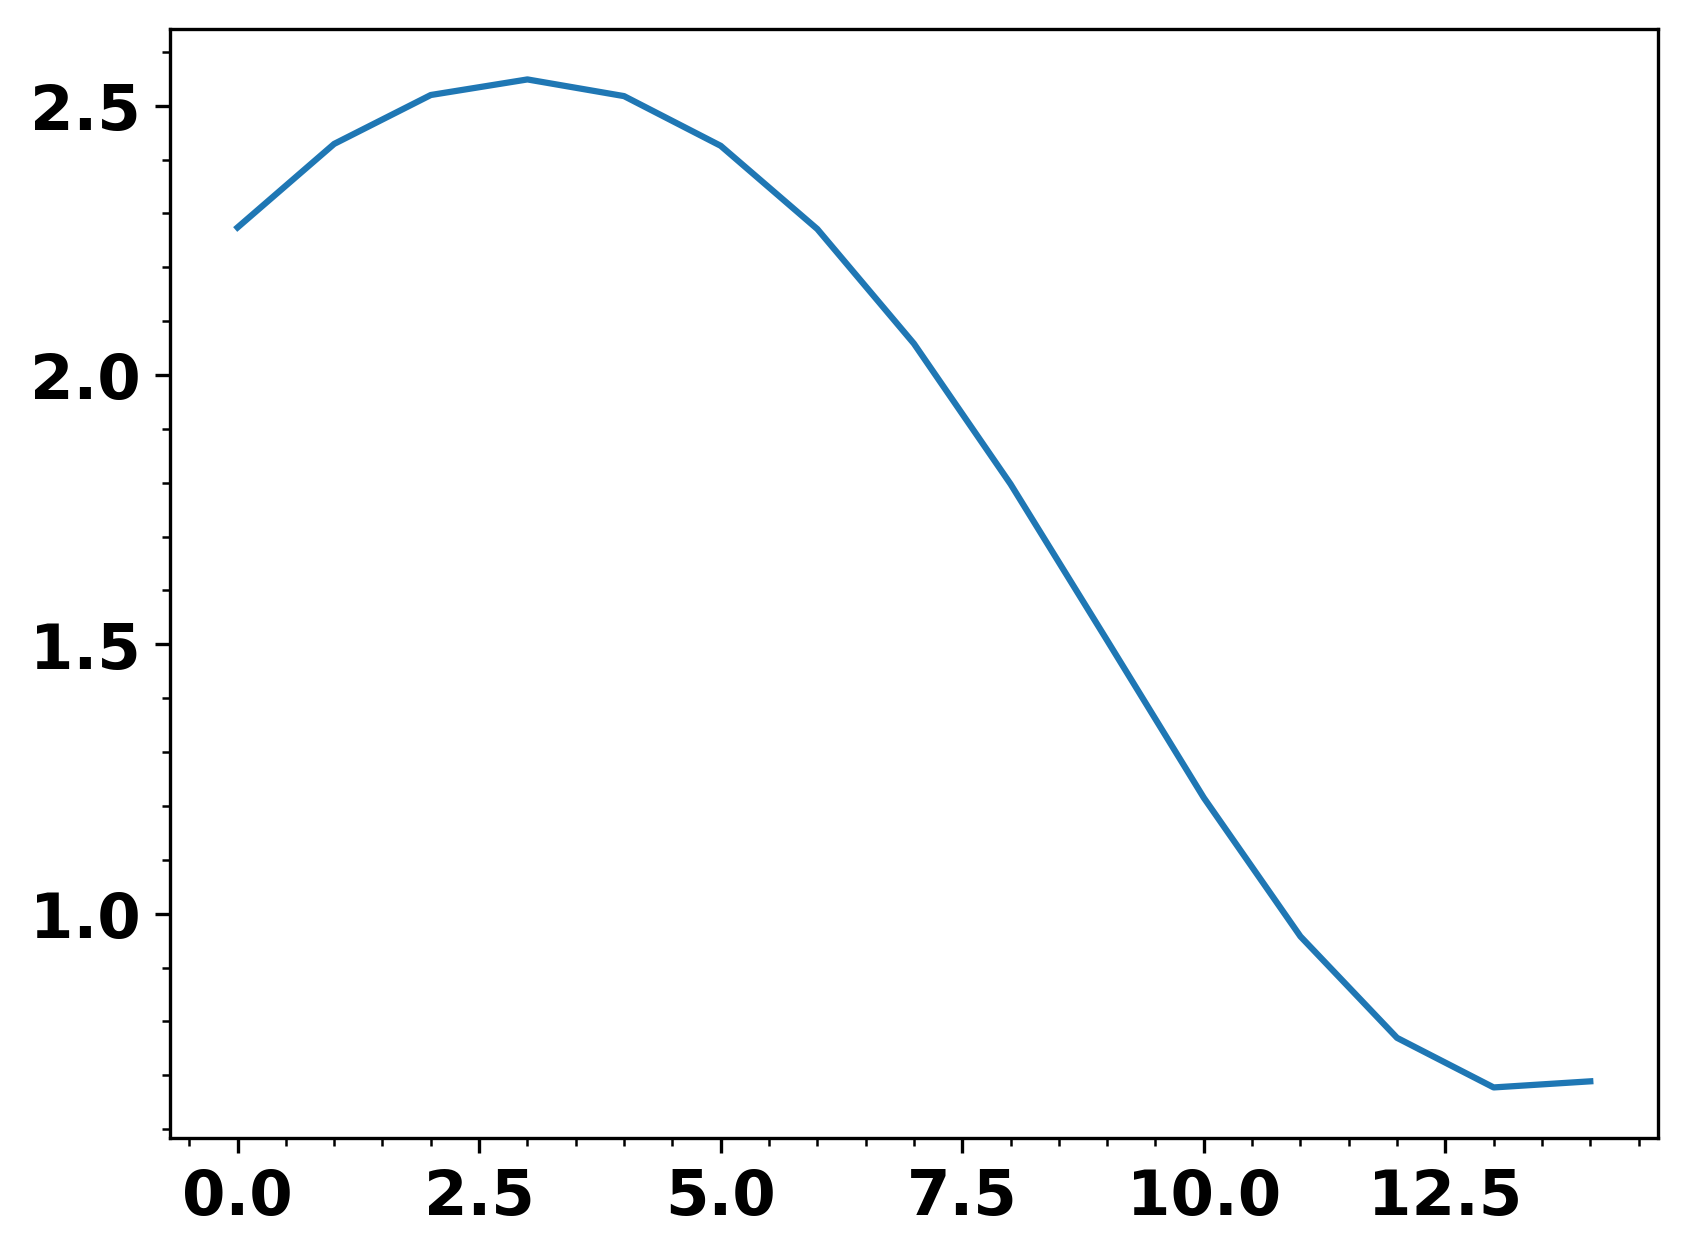

In [2]:
force = []
mol = read("Data/Model_test/EtOH_moldyn_data.xyz", index=':')
for atom in mol:
    force.append(atom.get_forces()[2,0])

plt.plot(range(len(force[5020:5035])), force[5020:5035])

In [25]:
#The function takes arrays of forces and returns a VAR OLS model
#_____Inputs______
# main - 1D np array with the time series which the model fits to.
# secondary - 2D np array with the secondary time series used to predict the main time series
# order - Positive integer which decides the numper of points in the past is used to predict the next point
#
#_____Output______
# Returns a OLS model that uses the main and secondary time series to predict the main time series. In order to predict t+2 of the main timeseries,
# t+1 of both main and secondary time series must be known. If the values of the secondary time series is not known this can be done by also creating models
# for the secondary time series and use those to predict the value at t+1
def create_AR_OLS_model(time_series, order=2):
    input = len(time_series)-order
    X = np.zeros([input,order+1])
    for i in range(order):
        X[:,i] = time_series[i:input+i]
    X[:,-1] = np.ones(input)
    return sm.OLS(time_series[order:], X)


# Returns 3 fitted models from create_VAR_OLS_model to create 3 models to respectively predict the forces in x, y, and z direction for an atom in a molecule.
# Uses L2 regularized fitting.
#_____Inputs______
# forces - 2D np array with the three force time series for the atom chosen. Has the shape [N, 3] where N is the number of input points in the model.
# order - Positive integer which decides the numper of points in the past is used to predict the next point
#
#_____Output______
# Returns 3 fitted VAR OLS which can be used to predict future points in the time series. t+1 must be predicted for all three time series before t+2 can be predicted.
def create_atom_OLS_model(forces, order=2):
    model_x = create_AR_OLS_model(forces[0,:], order=order).fit_regularized(method="elastic_net", L1_wt=0)
    model_y = create_AR_OLS_model(forces[1,:], order=order).fit_regularized(method="elastic_net", L1_wt=0)
    model_z = create_AR_OLS_model(forces[2,:], order=order).fit_regularized(method="elastic_net", L1_wt=0)
    return model_x, model_y, model_z

# Function which predicts the forces on the atoms in a molecule for a certain number of time steps
#_____Inputs______
# file - String with the name of the xyz file containing information on the molecule
# input - Positive integer with the number of data points used as input in training the OLS VAR models
# pred_step - Positive integer which decides the number of time steps predicted by the OLS VAR models
# order - Positive integer which decides the numper of points in the past is used to predict the next point
#
#_____Output______
# Returns a 3D np array with the predicted forces. The array as the following shape [N, 3, p], with N being the number of atoms in the molecule
# and p being the number of time steps predicted
def predict_forces(mol, input=6, pred_step=1, order=2):
    #mol = read(file, index=slice(-input, None))
    n_atoms = mol[0].get_global_number_of_atoms()
    predicted_forces = np.zeros((n_atoms, 3, pred_step))
    forces = np.zeros((n_atoms, 3, input))

    for i in range(len(mol)):
        forces[:,:,i] = mol[i].get_forces()
    for i in range(n_atoms):
    
        model_x, model_y, model_z = create_atom_OLS_model(forces[i,:,:], order=order)
        forecast_forces = np.zeros((3, pred_step+order))
        forecast_forces[:,:order] = forces[i,:,-order:]
        for j in range(pred_step):
            input_x = np.array([forecast_forces[0,j], forecast_forces[0,j+1], 1])
            input_y = np.array([forecast_forces[1,j], forecast_forces[1,j+1], 1])
            input_z = np.array([forecast_forces[2,j], forecast_forces[2,j+1], 1])
            forecast_forces[0,order+j] = model_x.predict(input_x)
            forecast_forces[1,order+j] = model_y.predict(input_y)
            forecast_forces[2,order+j] = model_z.predict(input_z)
        predicted_forces[i,:,:] = forecast_forces[:,order:]
        
    return predicted_forces

# Average difference in positions between timesteps

In [4]:
mol = read("Data/Model_test/EtOH_moldyn_data.xyz", index=':')

av_position_difference = []

for i in range(len(mol)-1):
    av_position_difference.append(((np.abs(mol[i+1].get_positions()-mol[i].get_positions()))))
pos_dif = np.asanyarray(av_position_difference).flatten()
mean_diff, var_diff = np.mean(av_position_difference), np.var(av_position_difference)
print(np.mean(pos_dif), np.var(pos_dif))

0.007288001555705504 4.7412415936321626e-05


# Evaluating model with input and pred

In [22]:
mae = []
k=0
def evaluate_model(mol, input=6, pred_step=6, dt=0.5*units.fs, model="AR", order=2):
    mae = []
    k=0
    while k < len(mol)-input-pred_step-20:
        #print(k, input)
        if model == "AR":
            predicted_forces = predict_forces(mol[k:k+input], input=input, pred_step=pred_step, order=order)
        elif model =="ARIMA":
            predicted_forces = predict_forces(mol[k:k+input], input=input, pred_step=pred_step, order=order)
        else:
            print("Please choose a valid model")
            return
        temp_mol = mol[k+input-1]
        #Repurposing the step function from ASE velverlet
        for i in range(pred_step):
            #Get masses for the atoms in the molecule
            masses = temp_mol.get_masses()[:, np.newaxis]

            #Get the forces, momenta, and positions for the current step
            #forces = mol[i].get_forces()
            force_step = predicted_forces[:,:,i] 
            p = temp_mol.get_momenta()
            r = temp_mol.get_positions()
            
            #Calculate new momenta and positions
            p += 0.5 * dt * force_step
            temp_mol.set_positions(r + dt * p / masses)
            error = temp_mol.get_positions()-mol[k+input+i].get_positions()
            mae.append(np.abs(error))
            #Was in ase.step. Unsure if needed
            if temp_mol.constraints:
                p = (temp_mol.get_positions() - r) * masses / dt

            #Momenta needs to be stored before possible calculations of forces
            temp_mol.set_momenta(p, apply_constraint=False)

            #Forces for next step is found either using predicted forces or gpaw calculator
            if i<pred_step-1:
                force_step = predicted_forces[:,:,i+1]
            
            
            #Calculate and set momenta for the next step
            temp_mol.set_momenta(temp_mol.get_momenta() + 0.5 * dt * force_step)
        k+=input+pred_step
    return np.asarray(mae)

In [6]:
mol = read("Data/Model_test/EtOH_moldyn_data.xyz", index=':5000')
input, pred_step = 4, 4
mae = evaluate_model(mol=mol, input=input, pred_step=pred_step, model="AR", order=2)

mae = 0.0015098129153696882 +- 0.001349110990517306
[0.01889788 0.08483186 0.22385687 0.50107013] [0.00012302 0.00055981 0.00168825 0.04181215]


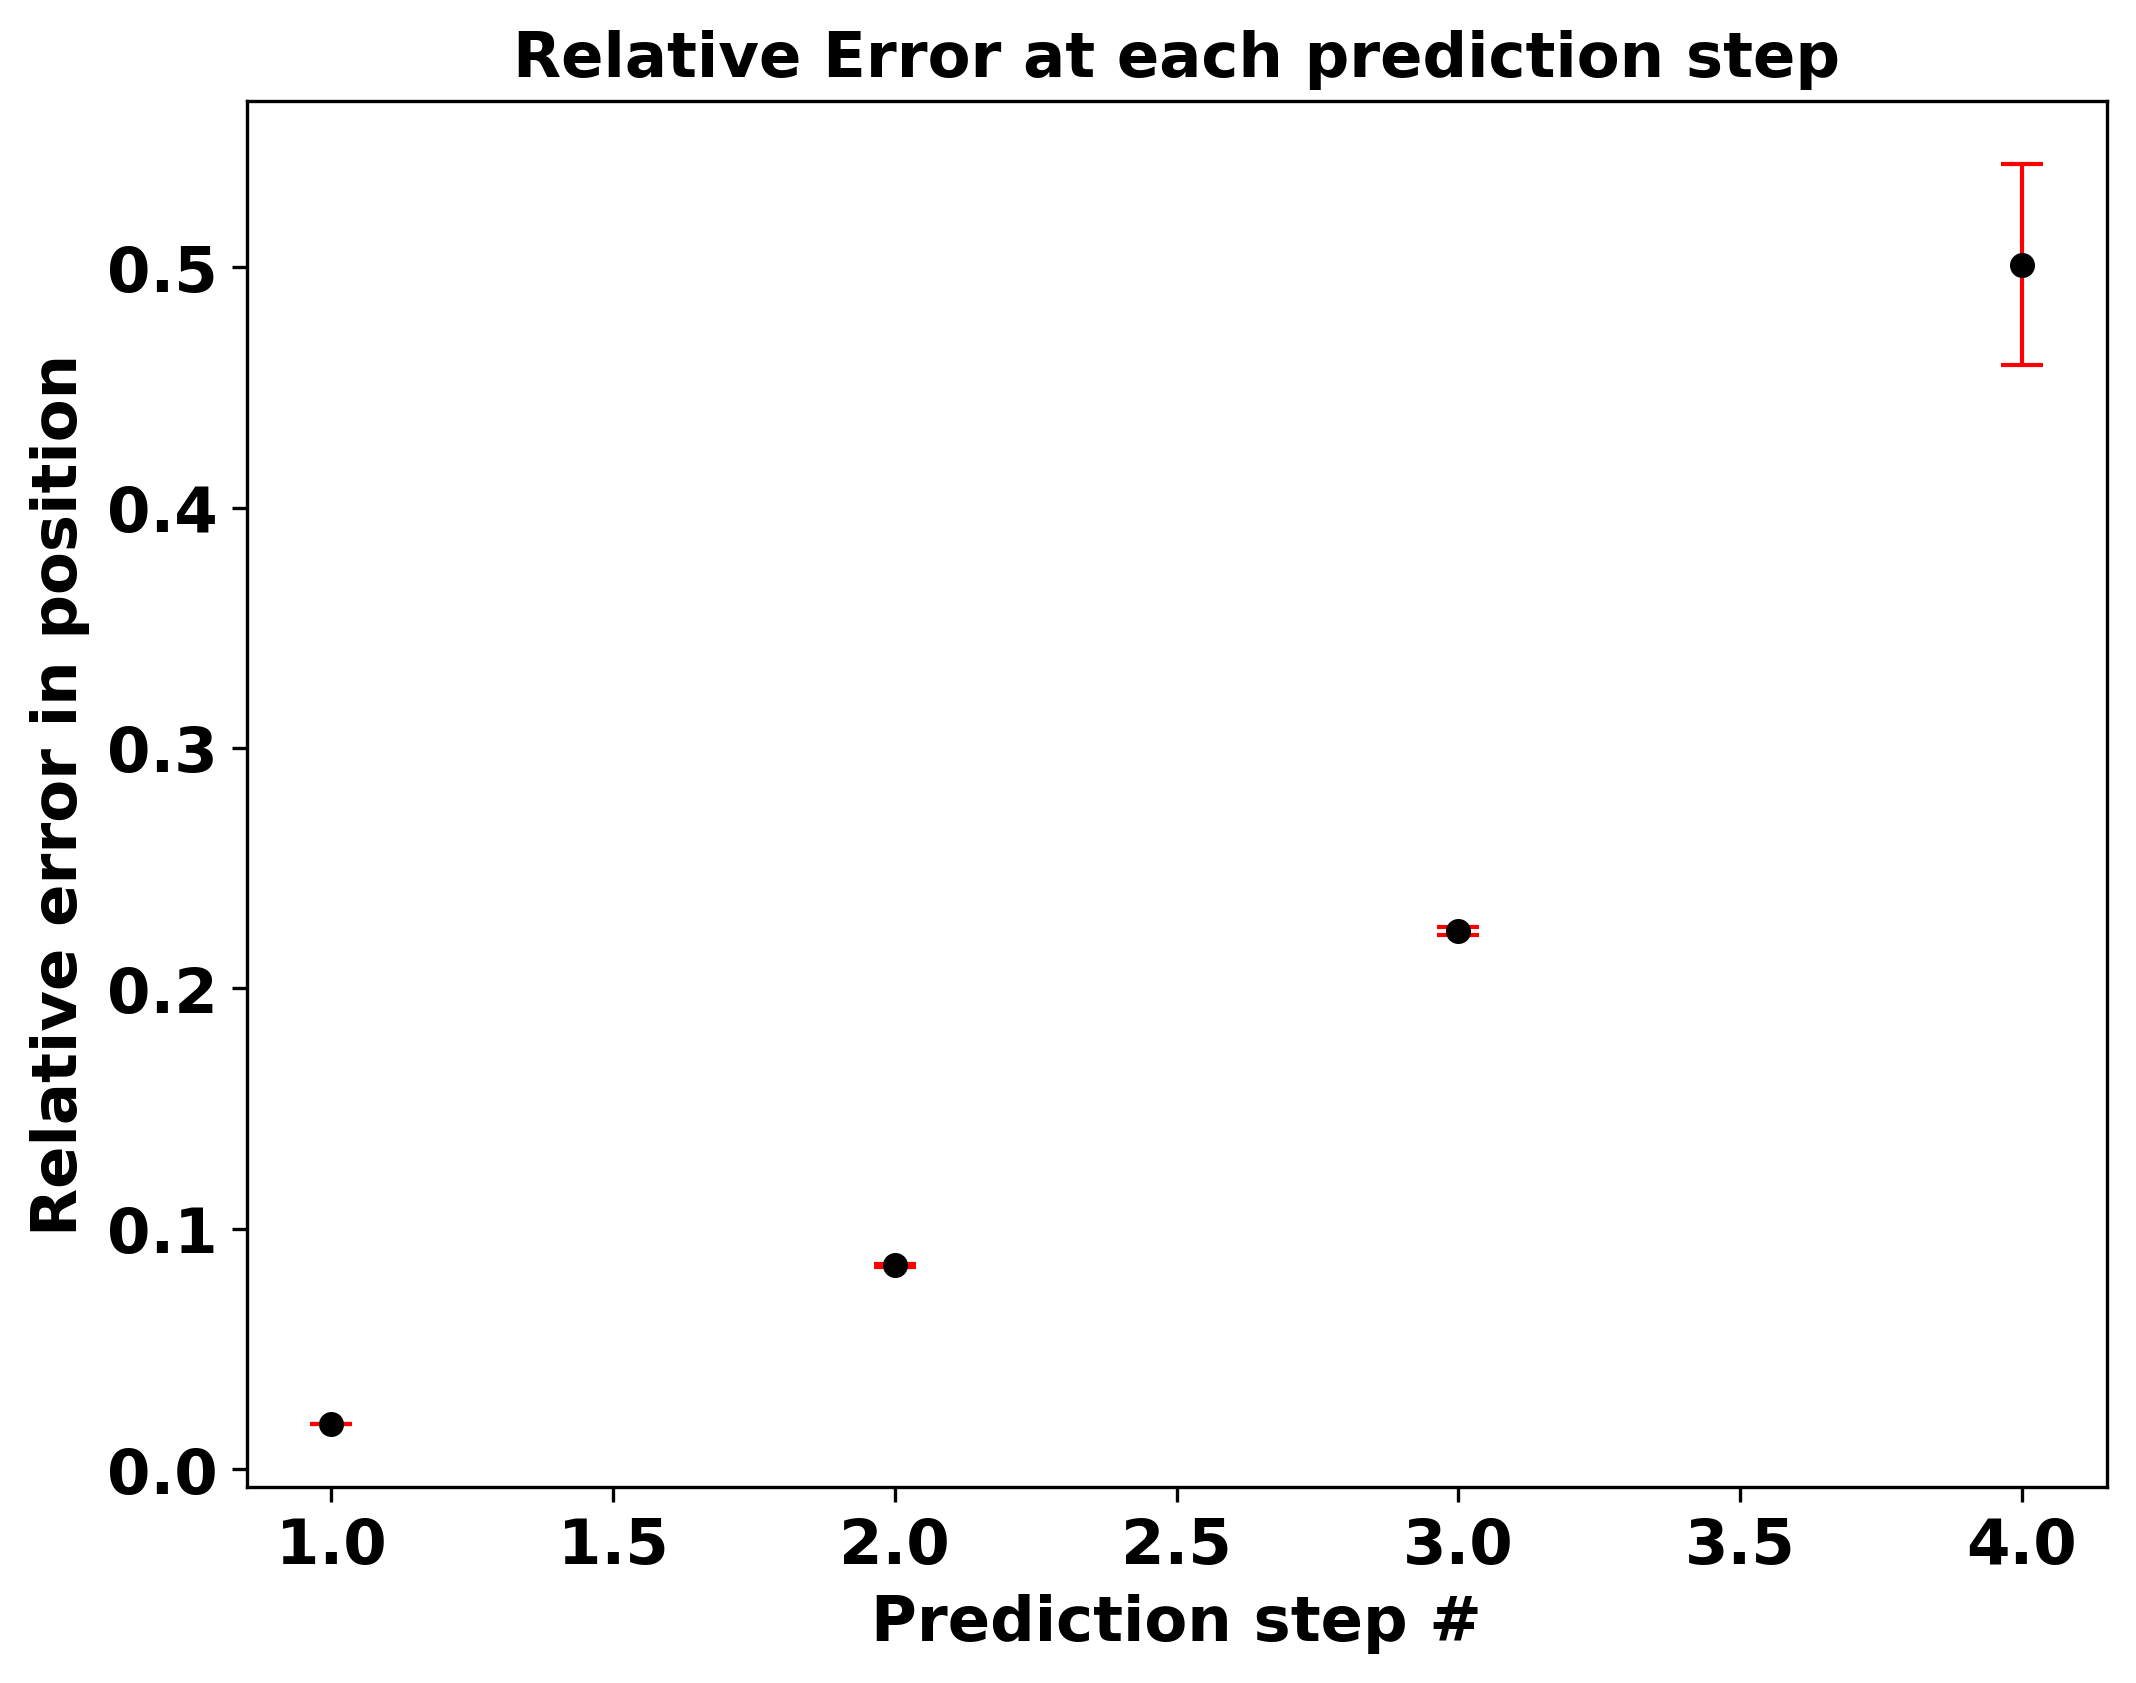

In [7]:
mae_step = []
var_step = []

for i in range(pred_step):
    mae_step.append(np.mean(mae[i::pred_step,:,:]))
    var_step.append(np.var(mae[i::pred_step,:,:]))
mae_step, var_step = np.asarray(mae_step), np.asarray(var_step)
print("mae =",np.mean(mae_step), "+-", np.std(mae_step))
y_std = np.sqrt((var_step/mae_step)**2+(var_diff/mean_diff)**2)*mae_step/mean_diff
print(mae_step/mean_diff, y_std)

fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(range(1, pred_step+1), mae_step/mean_diff, yerr=y_std, fmt='.k',  ecolor='r', elinewidth=1, capsize=5, capthick=1, ms=10)
#ax.set_xlim(0.5, 4.5)
#ax.set_ylim(0, 0.29)
ax.set_ylabel("Relative error in position", fontweight="bold")
ax.set_xlabel("Prediction step #", fontweight="bold")
ax.set_title("Relative Error at each prediction step", fontweight="bold")
ax.minorticks_off()

624.0
mae = 0.0015098129153696877 +- 7.95050878946735e-05
[0.00013772780486049323, 0.0003779912840981134, 0.0007958172639138853, 0.0015098129153696877]


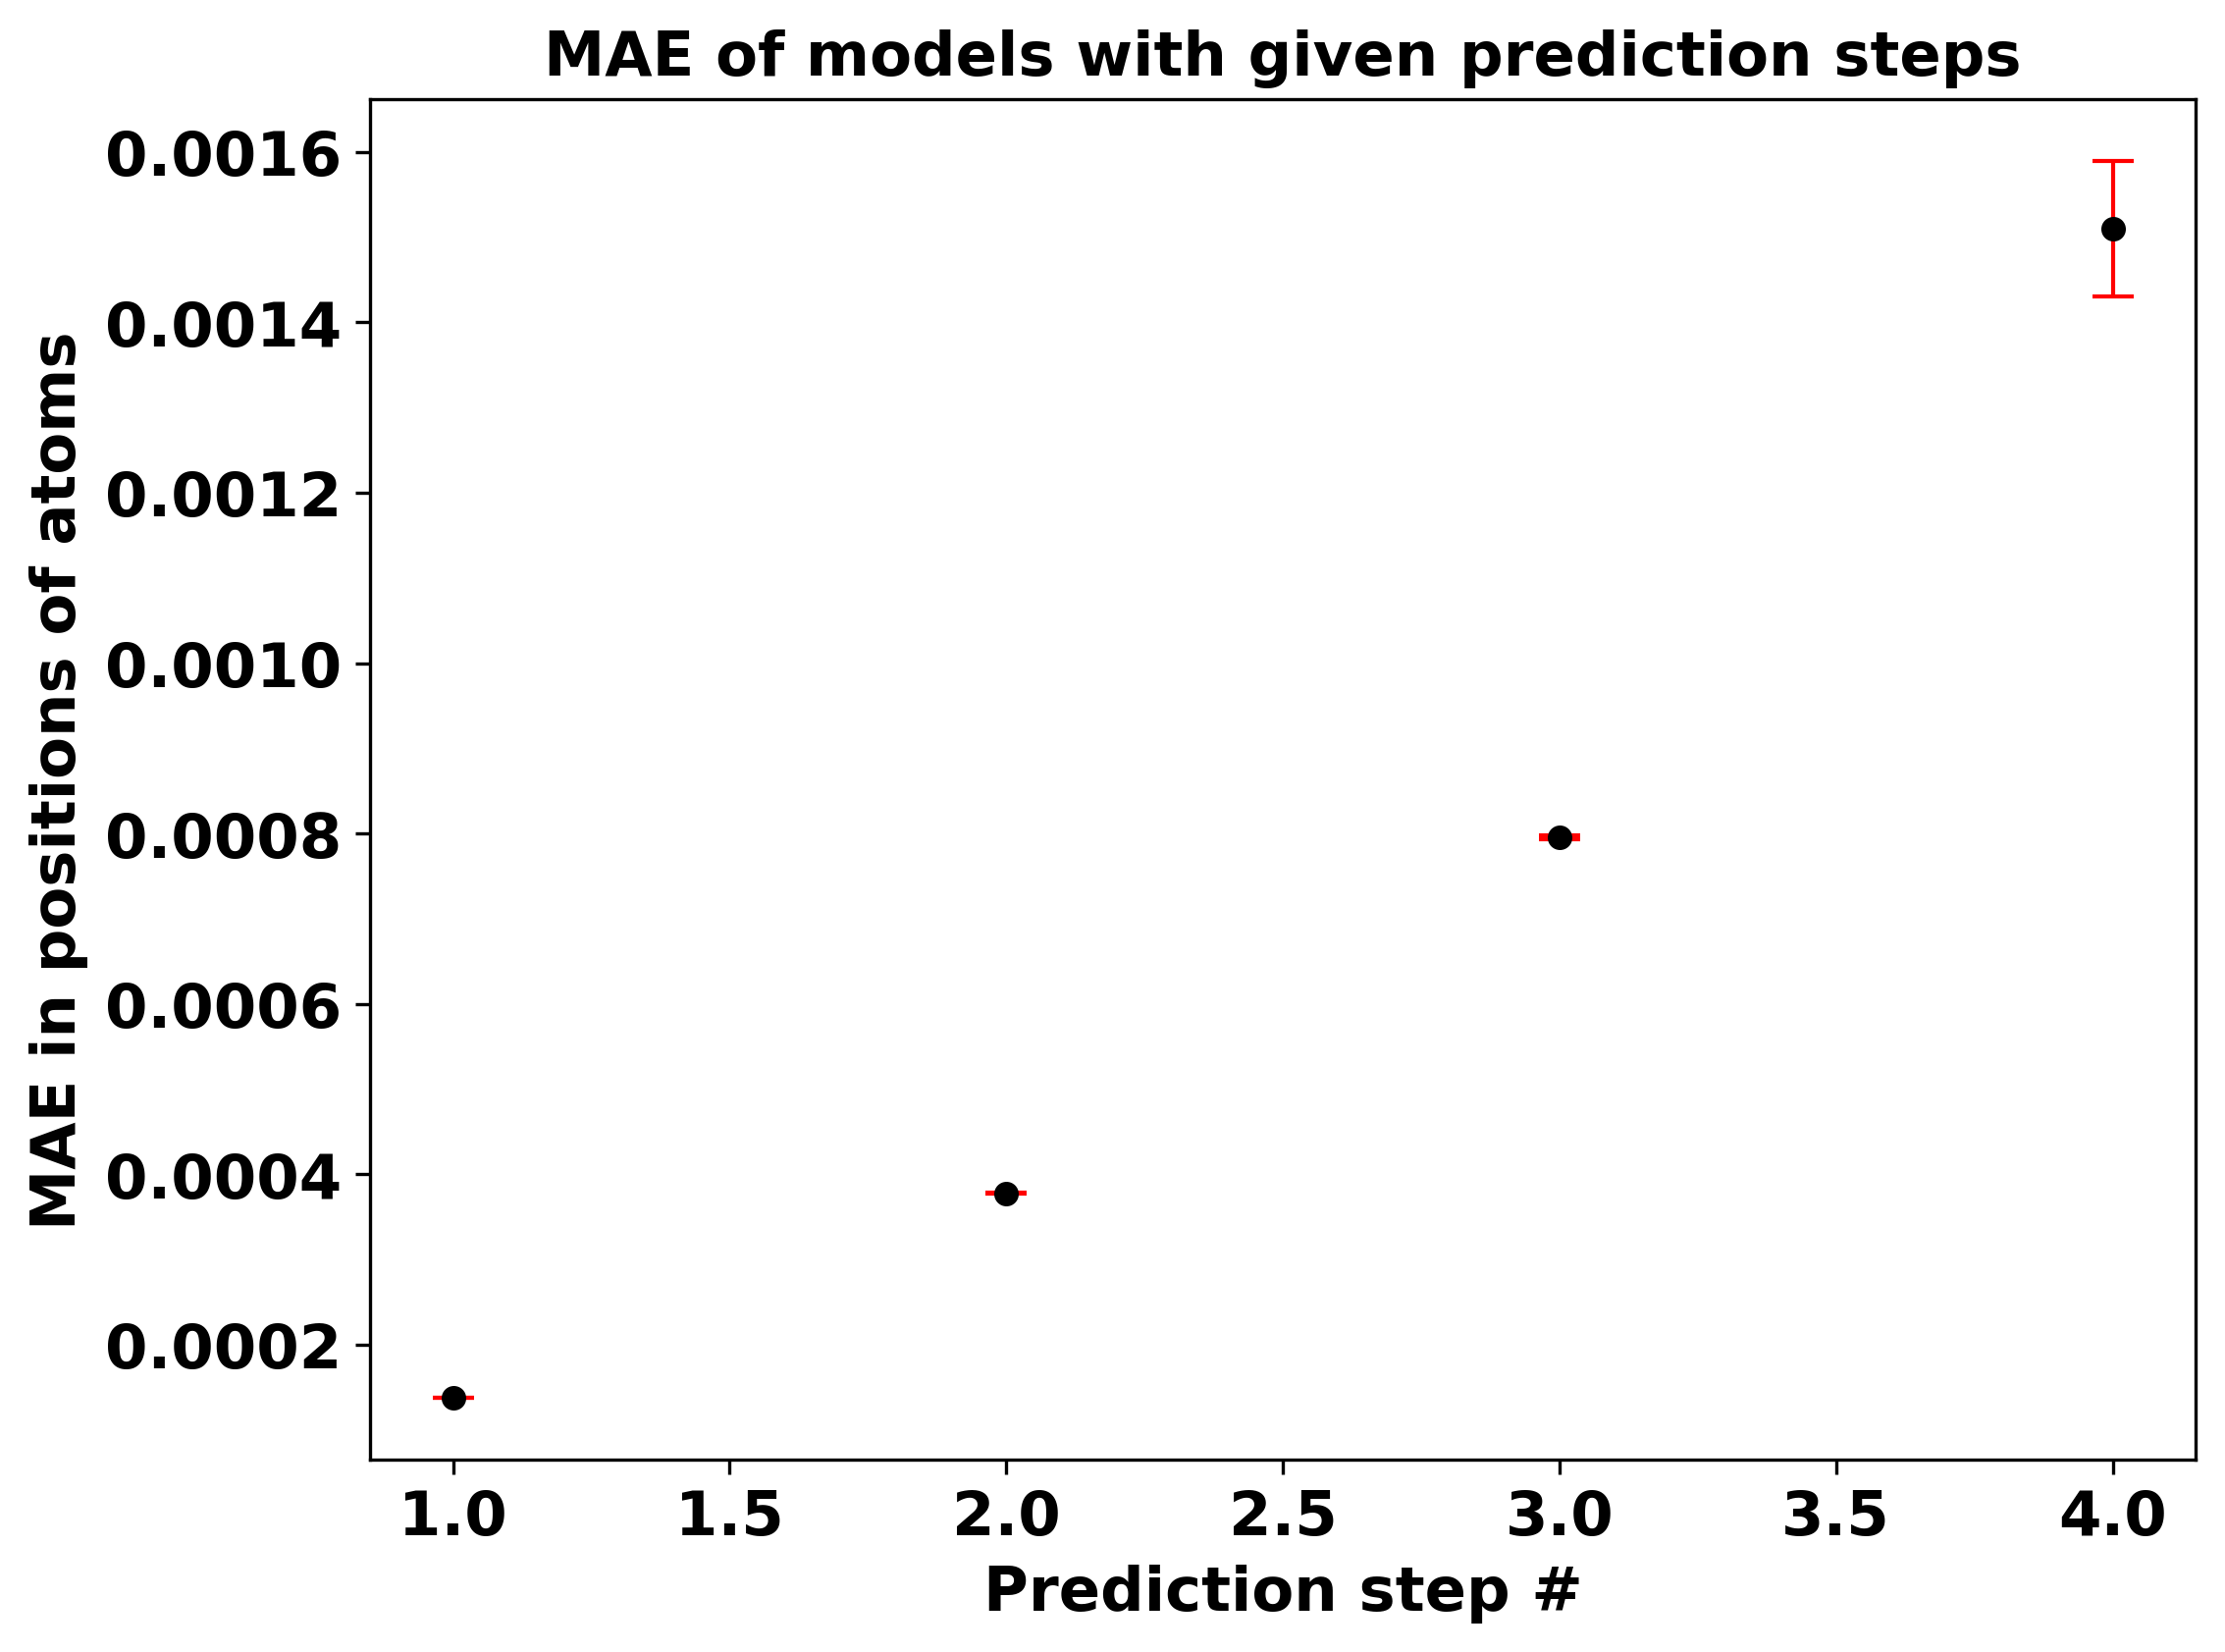

In [8]:
print(len(mae)/pred_step)
mae_steps = np.ones([pred_step, int(len(mae)/pred_step), 9, 3])
mae_model = []
var_model = []


for i in range(pred_step):
    mae_steps[i,:,:,:] = mae[i::pred_step,:,:]

for i in range(pred_step):
    mae_model.append(np.mean(mae_steps[:i+1,:]))
    var_model.append(np.var(mae_steps[:i+1,:]))
print("mae =",np.mean(mae), "+-", np.var(mae))
print(mae_model)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(range(1, pred_step+1), mae_model, yerr=np.array(var_model), fmt='.k',  ecolor='r', elinewidth=1, capsize=5, capthick=1, ms=10)
#ax.set_xlim(0.5, 4.5)
#ax.set_ylim(0, 0.29)
ax.set_ylabel("MAE in positions of atoms", fontweight="bold")
ax.set_xlabel("Prediction step #", fontweight="bold")
ax.set_title("MAE of models with given prediction steps", fontweight="bold")
ax.minorticks_off()

# Heatmap of input and pred_step parameters

In [52]:
mol = read("Data/Model_test/EtOH_moldyn_data.xyz", index=':5000')

mae = np.zeros((13, 4))
for i in range(13):
    for j in range(4):
        mol = read("Data/Model_test/EtOH_moldyn_data.xyz", index=':5000')
        print(i, j)
        mae[i, j] = np.mean(evaluate_model(mol=mol, input=i+4, pred_step=j+1, model="AR", order=2))

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3
4 0
4 1
4 2
4 3
5 0
5 1
5 2
5 3
6 0
6 1
6 2
6 3
7 0
7 1
7 2
7 3
8 0
8 1
8 2
8 3
9 0
9 1
9 2
9 3
10 0
10 1
10 2
10 3
11 0
11 1
11 2
11 3
12 0
12 1
12 2
12 3


[[1.38051953e-04 3.80378091e-04 7.92558901e-04 1.51103834e-03]
 [1.85662310e-04 2.50729643e-01 4.61110188e+00 3.34725175e+04]
 [1.28608675e-04 3.43396361e-04 7.33318273e-04 2.61925600e-02]
 [1.28033732e-04 3.23530084e-04 6.29094061e-04 1.08755828e-03]
 [1.26922262e-04 3.22077905e-04 6.16455102e-04 1.06566489e-03]
 [1.27316447e-04 3.22663756e-04 6.27994465e-04 1.02672789e-03]
 [1.27297608e-04 3.27071036e-04 6.12565668e-04 1.06053088e-03]
 [1.28362674e-04 3.19238649e-04 6.26181807e-04 1.07888764e-03]
 [1.26379869e-04 3.25553236e-04 6.37503280e-04 1.11907030e-03]
 [1.27635269e-04 3.27625382e-04 6.54017959e-04 1.12849406e-03]
 [1.28081690e-04 3.34868220e-04 6.55267922e-04 1.14256631e-03]
 [1.29091738e-04 3.32117557e-04 6.67480432e-04 1.15627969e-03]
 [1.27860586e-04 3.38360734e-04 6.63540641e-04 1.16921886e-03]]


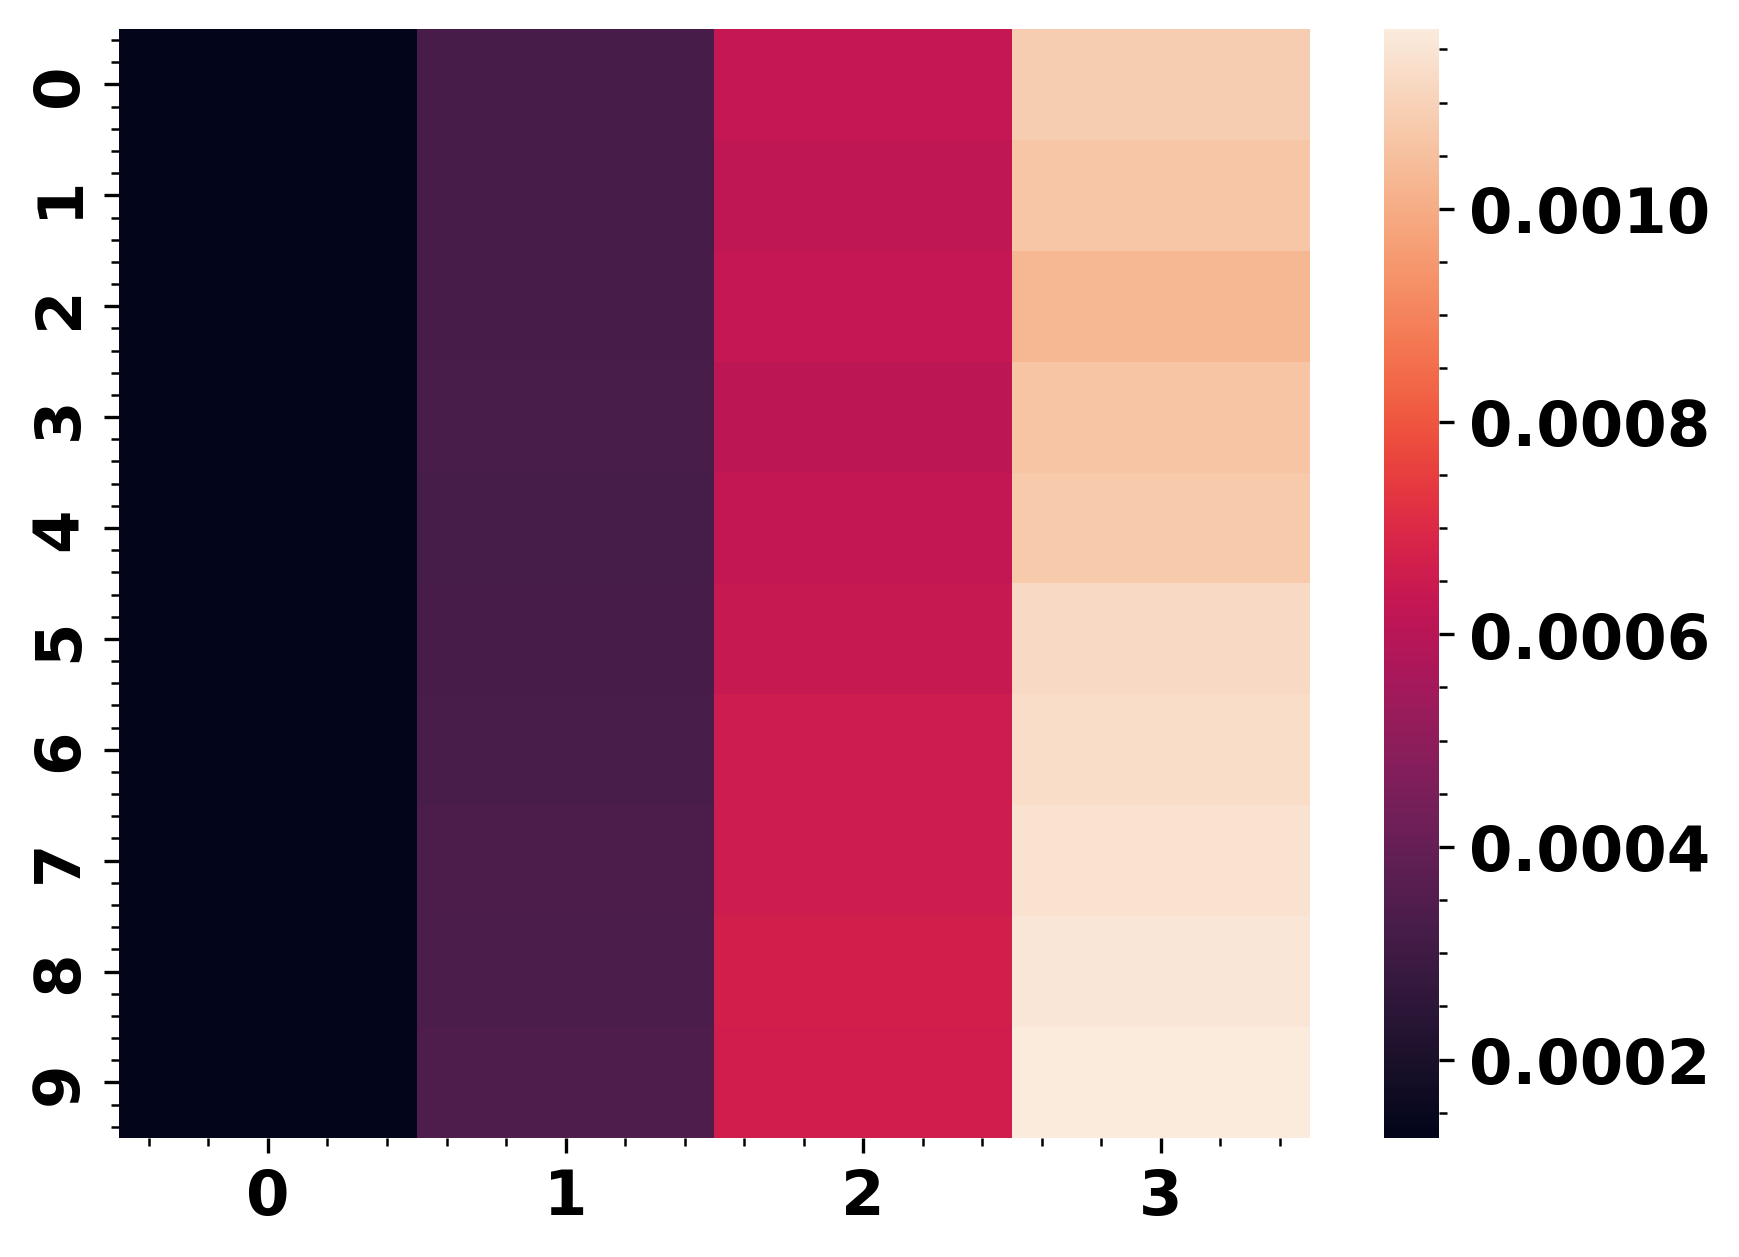

In [56]:
sns.heatmap(mae[3:,:])
print(mae)

[7.05506822e-04 8.36934488e+03 6.84947083e-03 5.42054040e-04
 5.32780039e-04 5.26175638e-04 5.31866299e-04 5.38167692e-04
 5.52126672e-04 5.59443169e-04 5.65196034e-04 5.71242354e-04
 5.74745205e-04]


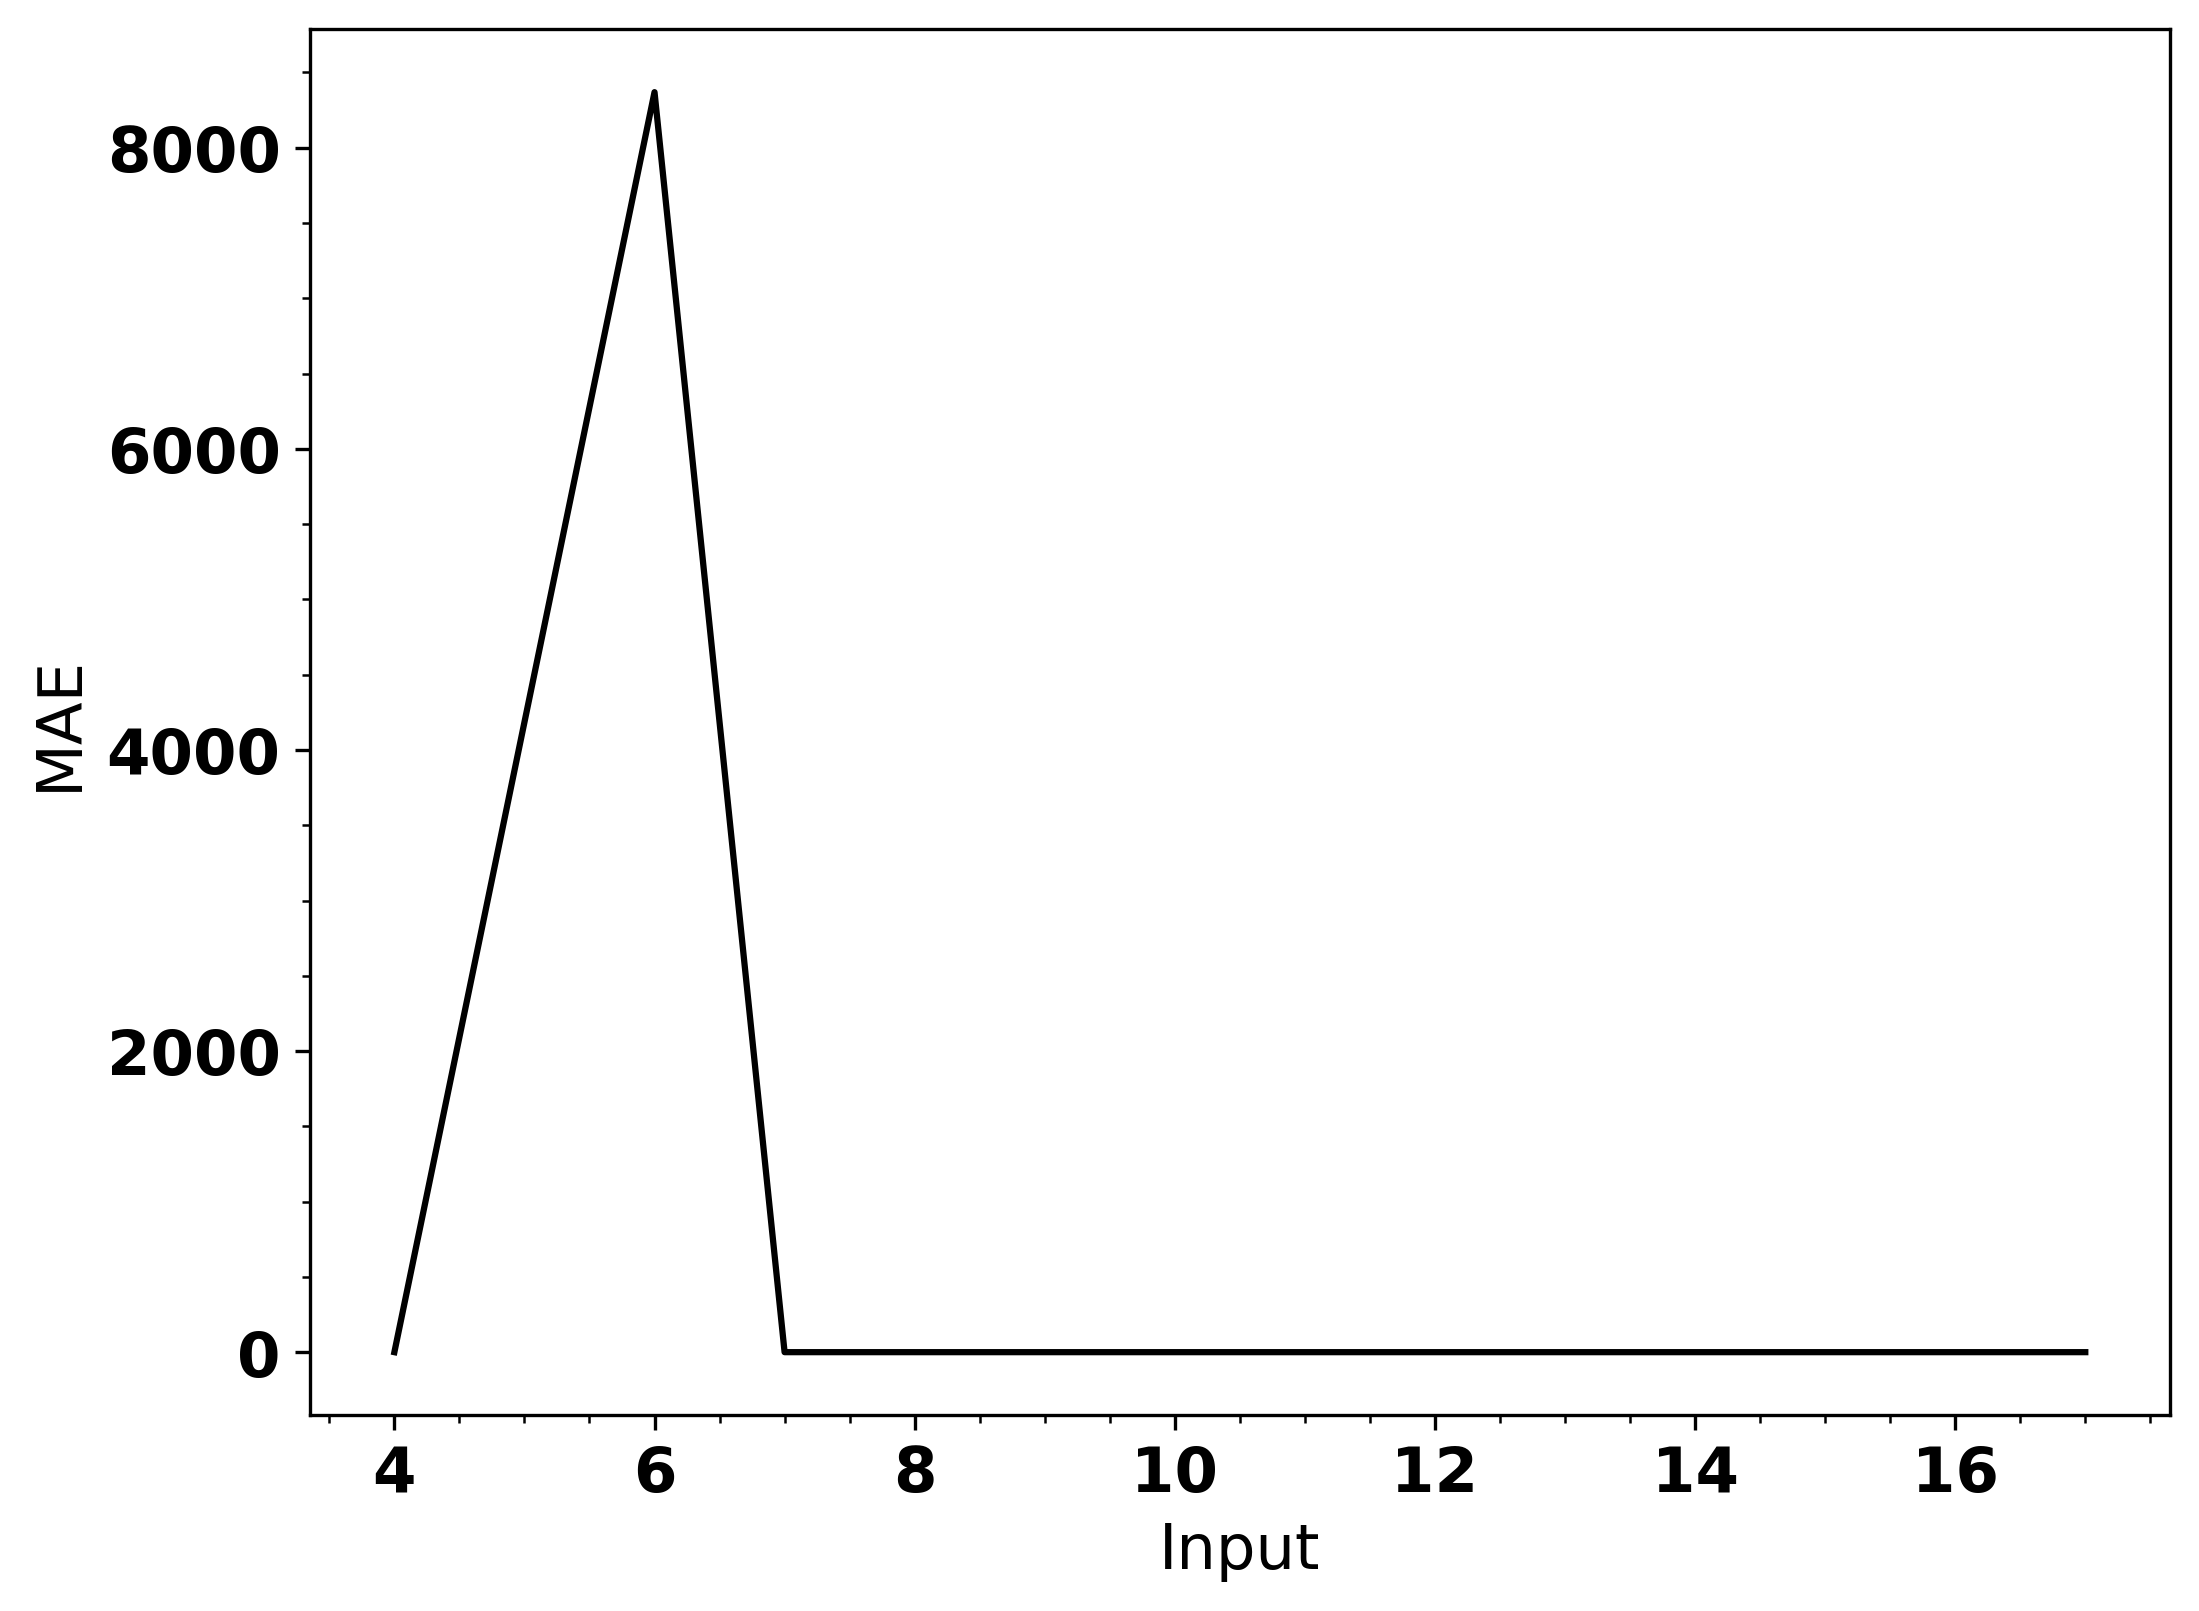

In [60]:
x = [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

mean_input = np.mean(mae,axis=1)
print(mean_input)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, mean_input, color="black")
ax.set_xlabel("Input")
ax.set_ylabel("MAE")
plt.show()

[0.00012864 0.00033307 0.00065966 0.00322822]


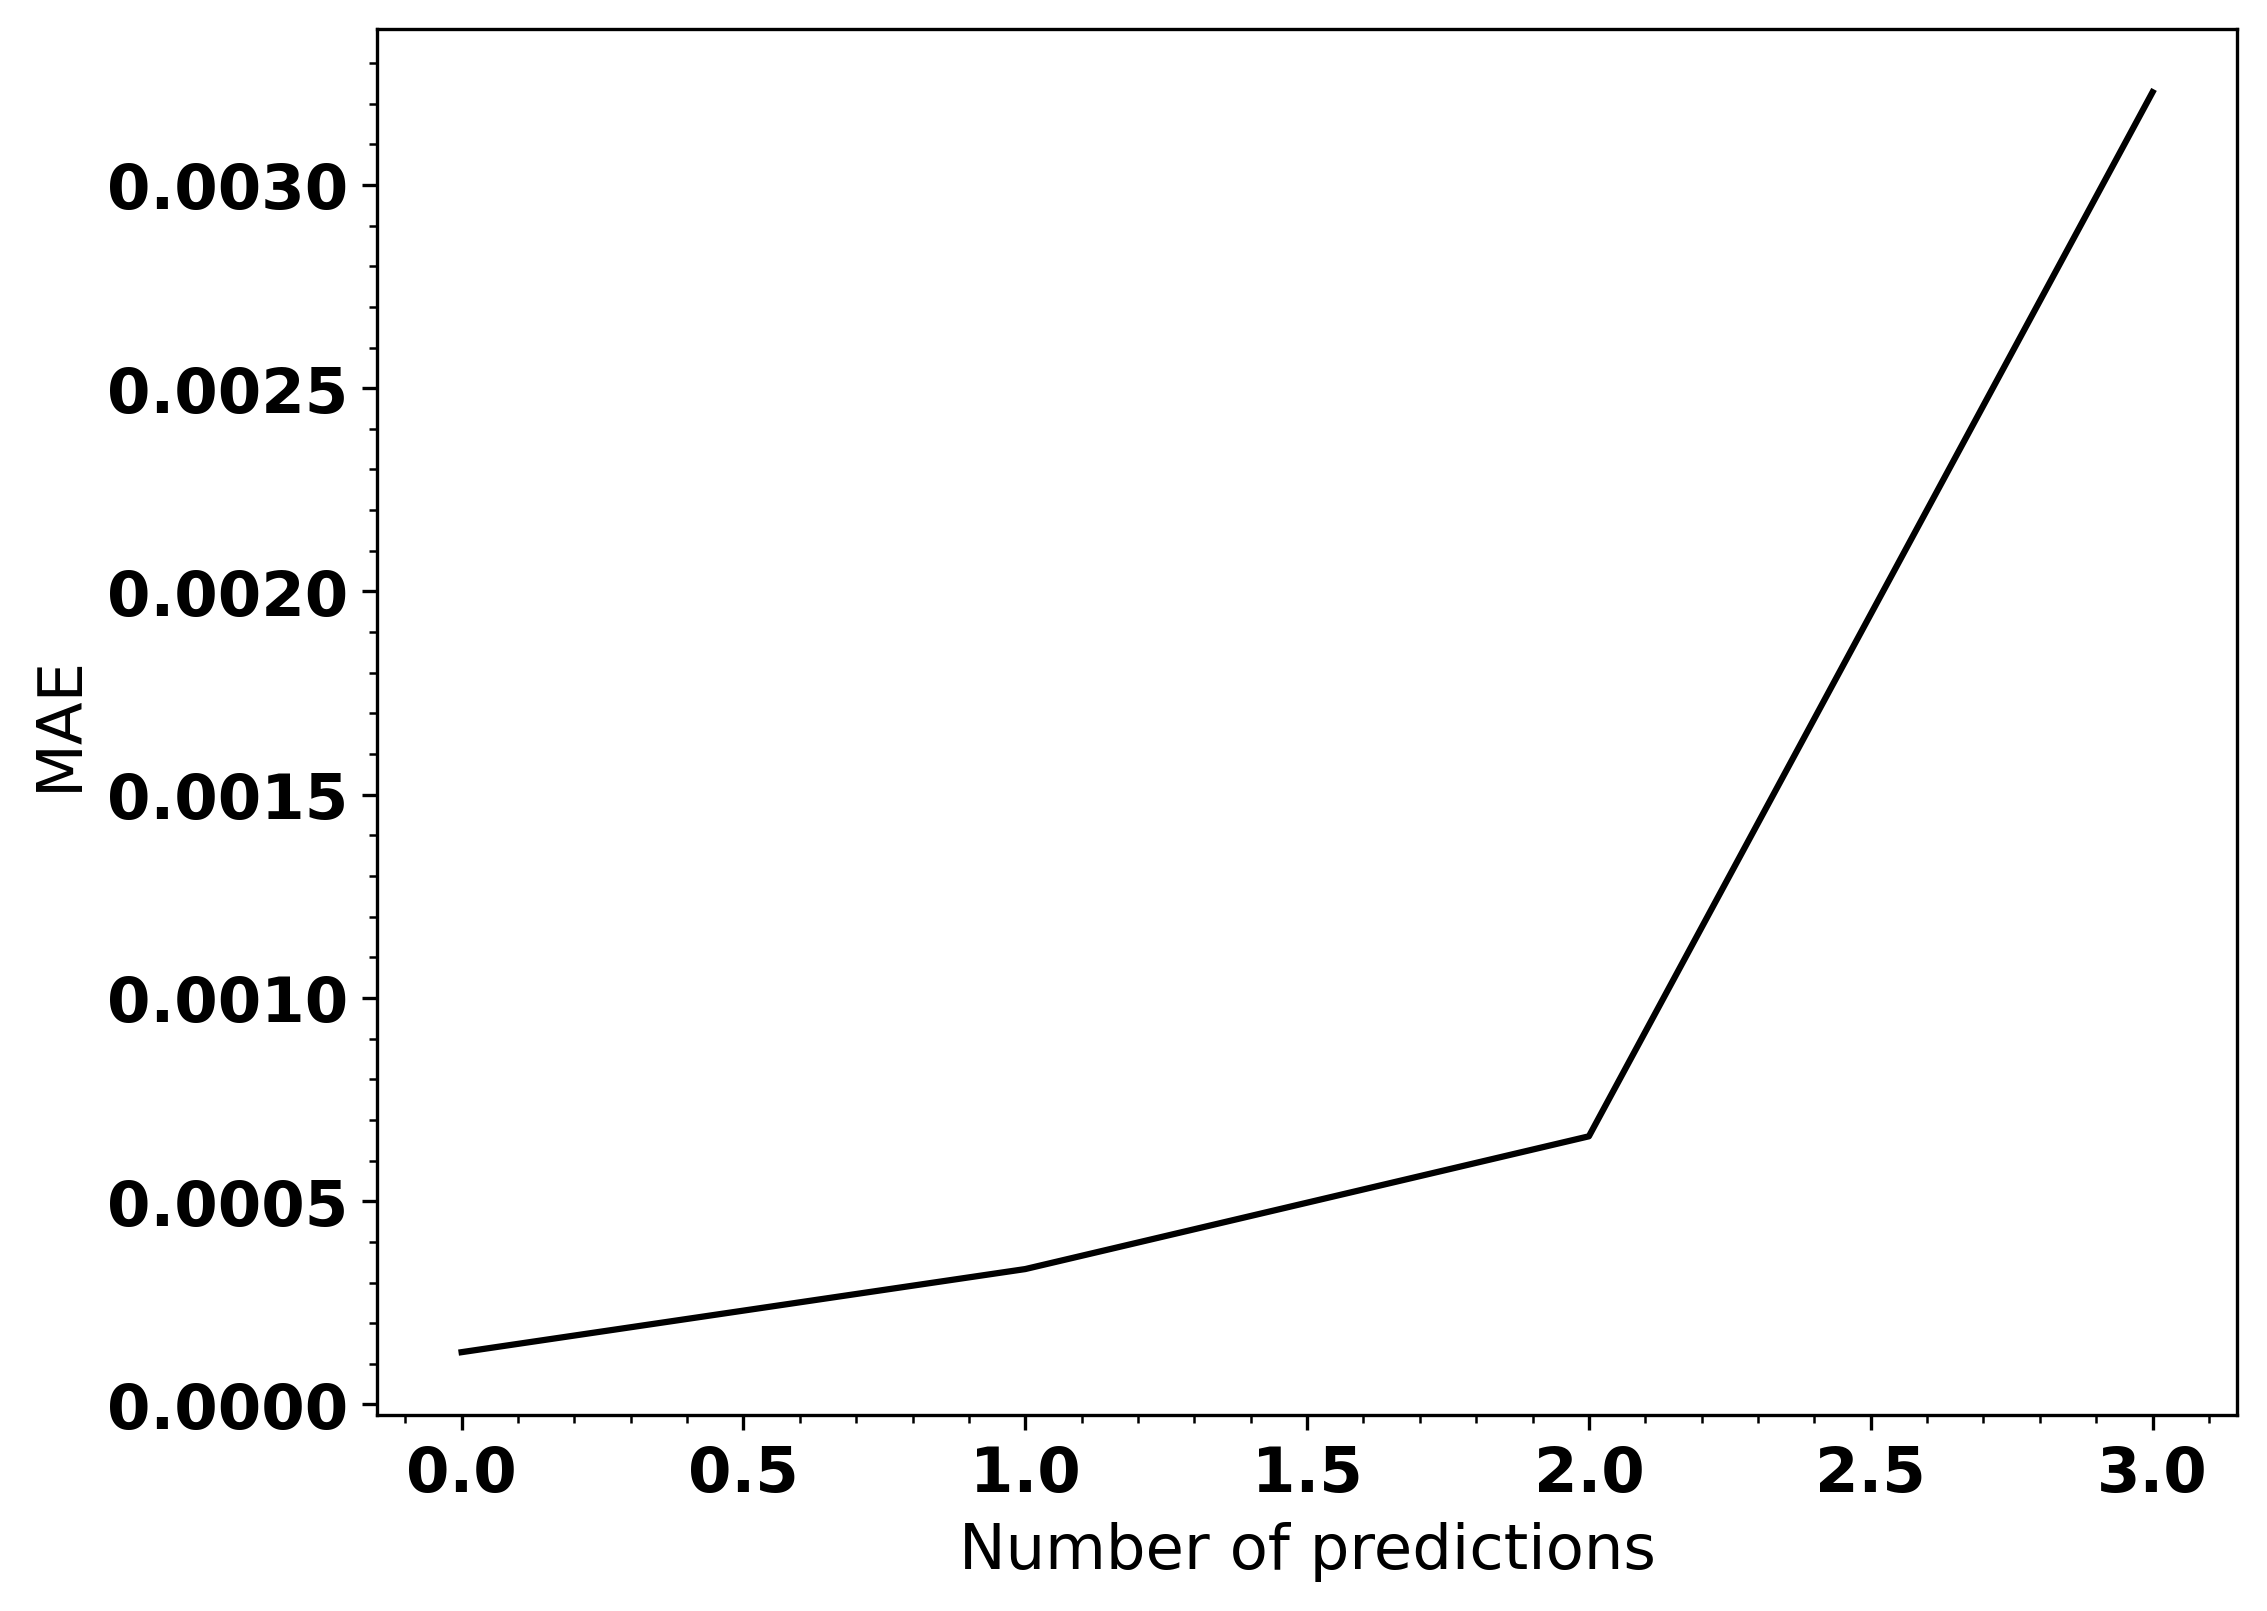

In [59]:


mean_pred = np.mean(np.delete(mae, 1, axis=0),axis=0)
print(mean_pred)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(4), mean_pred, color="black")
ax.set_xlabel("Number of predictions")
ax.set_ylabel("MAE")
plt.show()